In [1]:
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List
import numpy as np
from scipy.linalg import expm
from scipy.optimize import curve_fit

# basis = np.zeros((2**N, N))
# for i in range(2**N): 
#     basis[i, :] = np.array(list(np.binary_repr(i, width=N)), dtype=int)

In [2]:
Id = np.array([[1., 0.],
               [0., 1.]])

Z = np.array([[1., 0.],
              [0., -1.]])

X = np.array([[0., 1.],
              [1., 0.]])

In [3]:
@njit
def tp(A):
    prod = np.kron(A[0], A[1])
    for a in A[2:]:
        prod = np.kron(prod, a)
    return prod

tp(List([Id, Id, Id]));

In [4]:
def build_Hp(u, dw=0, A=100, B=1):
    N = 2*u + 1

    IdN = tp(List([Id for i in range(N)]))
    sigma_z = [tp(List((i)*[Id] + [Z] + (N-i-1)*[Id])) for i in range(N)]

    Hs = A/4 * (2*IdN + 2*sigma_z[0].dot(sigma_z[N-1])) # - 4*sigma_z[0] - 4*sigma_z[N-1] + 4*IdN)
    Ht = A/4 * (2*IdN + 2*sigma_z[u-1].dot(sigma_z[u])) # - 4*sigma_z[u-1] - 4*sigma_z[u] + 4*IdN)

    Hij = np.zeros(IdN.shape)
    for i in range(u-1):
        Hij += A/4 * (2*IdN - 2 * sigma_z[i].dot(sigma_z[i+1]))
    for i in range(u, N-1):
        Hij += A/4 * (2*IdN - 2 * sigma_z[i].dot(sigma_z[i+1]))

    HA = Hs + Ht + Hij

    # weight vector
    W = np.zeros(N)
    W[:u] = u + 1.
    W[u:] = u + dw

    HB = np.zeros(IdN.shape)
    for w, sigma in zip(W, sigma_z):
        HB += B / 2 * w * sigma
    HB += B / 2 * np.sum(W) * IdN
        
    return HA, HB

In [5]:
u = 1
N = 2*u+1

sigma_z = [tp(List((i)*[Id] + [Z] + (N-i-1)*[Id])) for i in range(N)]
    
HA , HB = build_Hp(u, A=25)

E, v = np.linalg.eigh(HA + HB)

for n in range(8):
    rep = list()
    for i in range(N):
        v = np.round(v)
        rep.append(v[:, n].dot(sigma_z[i].dot(v[:, n])))
    
    rep = map(lambda x: '0' if x == -1 else '1', rep)
    print(f'E = {E[n]:5.2f};', end='  ')
    print(' '.join(rep), end='  ')
#     print(int(v[:, n].dot(Hs.dot(v[:, n]))), end=' ')
#     print(int(v[:, n].dot(Ht.dot(v[:, n]))), end=' ')
#     print(int(v[:, n].dot(Hij.dot(v[:, n]))), end=' ')
    print()

E =  2.00;  1 0 0  
E =  2.00;  0 1 1  
E = 50.00;  0 0 0  
E = 51.00;  0 1 0  
E = 51.00;  0 0 1  
E = 53.00;  1 1 0  
E = 53.00;  1 0 1  
E = 54.00;  1 1 1  


In [6]:
u = 2
N = 2*u+1
    
HA , HB = build_Hp(u, A=25)
HA_dw, HB_dw = build_Hp(u, A=25, dw=-1)

sigma_x = [tp(List((i)*[Id] + [X] + (N-i-1)*[Id])) for i in range(N)]
Hin = np.zeros(sigma_x[0].shape)
for j in range(N):
    Hin += sigma_x[j]

steps = int(1e4) + 1
h_sweep = np.linspace(0, 1, steps)
dt = h_sweep[1] - h_sweep[0]

E1, E2, E3, E4 = np.zeros(steps), np.zeros(steps), np.zeros(steps), np.zeros(steps)
E1_c, E2_c, E3_c, E4_c = np.zeros(steps), np.zeros(steps), np.zeros(steps), np.zeros(steps)
E1_dw, E2_dw, E3_dw, E4_dw = np.zeros(steps), np.zeros(steps), np.zeros(steps), np.zeros(steps)

E, v = np.linalg.eigh(HA_dw + HB_dw)
v1, v2, v3, v4 = v[:, 0], v[:, 1], v[:, 2], v[:, 3]
v1 = v1.astype('complex128')
v2 = v2.astype('complex128')
v3 = v3.astype('complex128')
v4 = v4.astype('complex128')

for i, h in enumerate(h_sweep):
    H = (1-h)*(HA + HB) - h*Hin
    H_dw = (1-h)*(HA_dw + HB_dw) - h*Hin

    E, v = np.linalg.eigh(H)

    E1[i], E2[i], E3[i], E4[i] = E[:4]

#     v1 = expm(-1j*dt*H_dw).dot(v1)
#     v2 = expm(-1j*dt*H_dw).dot(v2)
#     v3 = expm(-1j*dt*H_dw).dot(v3)
#     v4 = expm(-1j*dt*H_dw).dot(v4)
    
    v1 += -1j*dt*H_dw.dot(v1)
    v2 += -1j*dt*H_dw.dot(v2)
    v3 += -1j*dt*H_dw.dot(v3)
    v4 += -1j*dt*H_dw.dot(v4)

    E1_c[i] = np.conj(v1).dot(H_dw.dot(v1))
    E2_c[i] = np.conj(v2).dot(H_dw.dot(v2))
    E3_c[i] = np.conj(v3).dot(H_dw.dot(v3))
    E4_c[i] = np.conj(v4).dot(H_dw.dot(v4))
    
    E1_dw[i], E2_dw[i], E3_dw[i], E4_dw[i] = np.linalg.eigh(H_dw)[0][:4]

/var/folders/5g/2335ntzx51d49vw09x7__6t40000gn/T/ipykernel_39852/3102889274.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  E1_c[i] = np.conj(v1).dot(H_dw.dot(v1))
/var/folders/5g/2335ntzx51d49vw09x7__6t40000gn/T/ipykernel_39852/3102889274.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  E2_c[i] = np.conj(v2).dot(H_dw.dot(v2))
/var/folders/5g/2335ntzx51d49vw09x7__6t40000gn/T/ipykernel_39852/3102889274.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  E3_c[i] = np.conj(v3).dot(H_dw.dot(v3))
/var/folders/5g/2335ntzx51d49vw09x7__6t40000gn/T/ipykernel_39852/3102889274.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  E4_c[i] = np.conj(v4).dot(H_dw.dot(v4))


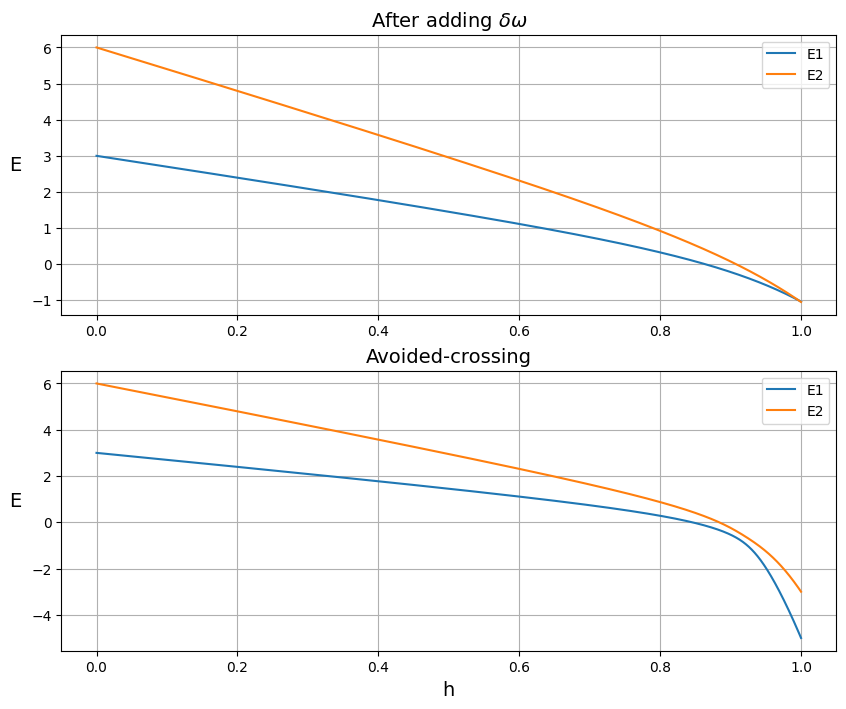

In [7]:
plt.figure(figsize=(10, 8))

# ax1 = plt.subplot(221)

# ax1.plot(h_sweep, E1, label='E1')
# ax1.plot(h_sweep, E2, label='E2')
# # ax1.plot(h_sweep, E3, label='E3')
# # ax1.plot(h_sweep, E4, label='E4')

# ax1.set_ylabel('E   ', fontsize=14, rotation='horizontal')
# ax1.set_title('Before adding $\\delta \\omega$', fontsize=14)
# ax1.legend()
# ax1.grid()

# ax2 = plt.subplot(222)
ax2 = plt.subplot(211)

ax2.plot(h_sweep, E1_c, label='E1')
ax2.plot(h_sweep, E2_c, label='E2')
# ax2.plot(h_sweep, E3_c, label='E3')
# ax2.plot(h_sweep, E4_c, label='E4')

ax2.set_ylabel('E   ', fontsize=14, rotation='horizontal')
ax2.set_title('After adding $\\delta \\omega$', fontsize=14)
ax2.legend()
ax2.grid()

ax3 = plt.subplot(212)

ax3.plot(h_sweep, E1_dw, label='E1')
ax3.plot(h_sweep, E2_dw, label='E2')
# ax3.plot(h_sweep, E3_dw, label='E3')
# ax3.plot(h_sweep, E4_dw, label='E4')

ax3.set_xlabel('h', fontsize=14)
ax3.set_ylabel('E   ', fontsize=14, rotation='horizontal')
ax3.set_title('Avoided-crossing', fontsize=14)
ax3.legend()
ax3.grid()

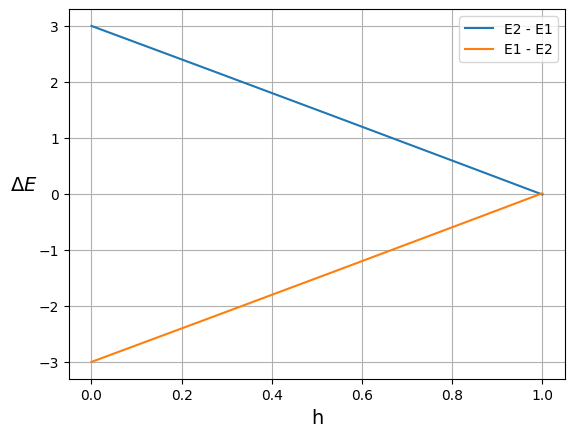

In [8]:
plt.plot(h_sweep, E2_c - E1_c, label='E2 - E1')
plt.plot(h_sweep, E1_c - E2_c, label='E1 - E2')
plt.xlabel('h', fontsize=14)
plt.ylabel('$\\Delta E$    ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()

In [9]:
steps = 101
h_sweep = np.linspace(0, 1, steps)

h_star = np.zeros(6)
for u in range(1, 7):
    
    N = 2*u + 1
    
    HA , HB = build_Hp(u, dw=-1)

    sigma_x = [tp(List((i)*[Id] + [X] + (N-i-1)*[Id])) for i in range(N)]
    Hin = np.zeros(sigma_x[0].shape)
    for j in range(N):
        Hin += sigma_x[j]

    E1 = np.zeros(steps)
    E2 = np.zeros(steps)

    for i, h in enumerate(h_sweep):
        H = (1-h)*(HA + HB) - h*Hin

        E, v = np.linalg.eigh(H)
        E1[i] = E[0]
        E2[i] = E[1]
    
    h_star[u-1] = h_sweep[np.argmin(np.abs(E2 - E1))]
    h_sweep = np.linspace(h_sweep[np.argmin(np.abs(E2 - E1)) - 1], 1, steps)

[ 1.02792494e+05  1.94688086e-04 -1.02797135e+05]
[12.37422361 -2.01156507 15.74140193]


/var/folders/5g/2335ntzx51d49vw09x7__6t40000gn/T/ipykernel_39852/3813271270.py:4: RuntimeWarning: invalid value encountered in log
  log_fit = lambda x, a, b, c: a * np.log(x + b) + c


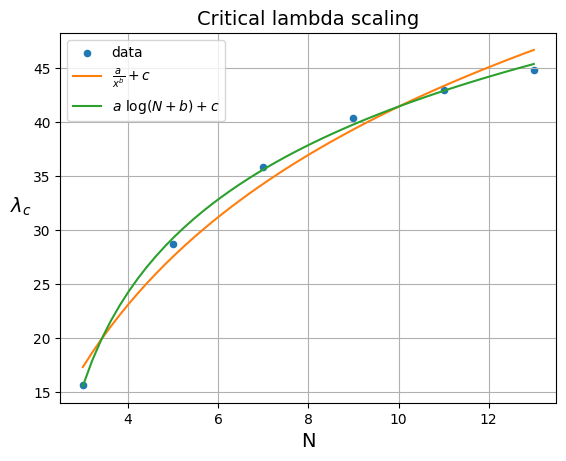

In [10]:
lambda_c = h_star / (1 - h_star)

power_fit = lambda x, a, b, c: a*x**b + c
log_fit = lambda x, a, b, c: a * np.log(x + b) + c

x_ = np.arange(1, 7)*2 + 1
x = np.linspace(1, 6)*2 + 1

plt.scatter(x_, lambda_c, label='data', s=20)

popt, pcov = curve_fit(power_fit, x_, lambda_c, maxfev=5000)
plt.plot(x, power_fit(x, *popt), label='$\\frac{a}{x^b} + c$ ', c='tab:orange')
print(popt)

popt, pcov = curve_fit(log_fit, x_, lambda_c, maxfev=10000)
plt.plot(x, log_fit(x, *popt), label='$a\\ \\log(N + b) + c $', c='tab:green')
print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$\\lambda_{c}$   ', fontsize=14, rotation='horizontal')
plt.title('Critical lambda scaling', fontsize=14)
plt.legend()
plt.grid()
# plt.savefig('lambda_c.svg')

In [11]:
Dmin = np.zeros(h_star.shape[0])

for i, h in enumerate(h_star):
    u = i + 1
    N = 2*u + 1
    
    HA , HB = build_Hp(u, dw=-1)

    sigma_x = [tp(List((i)*[Id] + [X] + (N-i-1)*[Id])) for i in range(N)]
    Hin = np.zeros(sigma_x[0].shape)
    for j in range(N):
        Hin += sigma_x[j]

    H = (1-h)*(HA + HB) - h*Hin

    E, v = np.linalg.eigh(H)
    
    Dmin[i] = E[1] - E[0]

[2.45402703e-05 2.77278683e+00 1.05287350e-01]


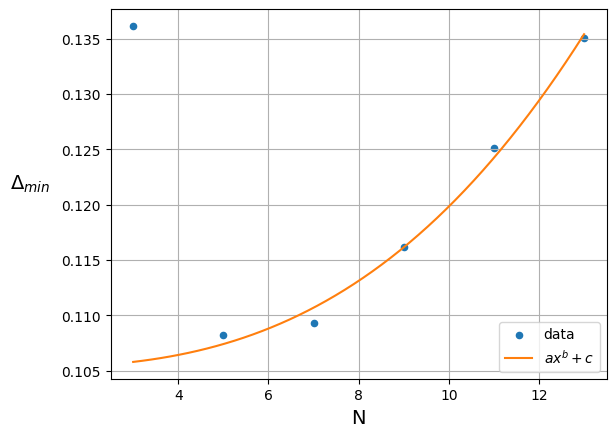

In [12]:
power_fit = lambda x, a, b, c: a * x**b + c
# log_fit = lambda x, a, b, c: a * np.log(x + b) + c

x_ = np.arange(1, 7)*2 + 1
x = np.linspace(1, 6)*2 + 1

plt.scatter(x_, Dmin, label='data', s=20)

popt, pcov = curve_fit(power_fit, x_[1:], Dmin[1:], p0=[1, 2, 1], maxfev=5000)
plt.plot(x, power_fit(x, *popt), label='$a x^b + c$ ', c='tab:orange')
print(popt)

# popt, pcov = curve_fit(log_fit, x_[1:], Dmin[1:], maxfev=5000)
# plt.plot(x, log_fit(x, *popt), label='log', c='tab:green')
# print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$\\Delta_{min}$         ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()
# plt.savefig('Dmin.svg')

In [13]:
for i in range(11, 20, 2):
    print(f'N = {i} {i * (2**(2*i) / 1e12 * 8):6.3f} TB')

N = 11  0.000 TB
N = 13  0.007 TB
N = 15  0.129 TB
N = 17  2.336 TB
N = 19 41.781 TB
